# Harringtonine CropArray Example

---

## Notebook summary 


- Load a microscope image of video
- Tracking spots on the image and generate a pandas dataframe with the spots locations
- Creating a croparray with the image and dataframe
- Signal quantification and plotting
- Visualization of croparray with Napari

----

## Importing libraries


----

In [1]:
# To manipulate arrays
import numpy as np 
from skimage.io import imread
import matplotlib.pyplot as plt 
from matplotlib.path import Path
import pylab as pyl
import seaborn as sns; sns.set()  
import pathlib # for working with windows paths
import sys
import cv2
import trackpy as tp
#!pip install shapely
from shapely.geometry import Polygon 
from shapely.geometry import Point
current_dir = pathlib.Path().absolute()
croparray_dir = current_dir.parents[0].joinpath('croparray')
sys.path.append(str(croparray_dir))
import crop_array_tools as ca
# %matplotlib inline 
plt.style.use('dark_background')

In [2]:
# Napari 
%gui qt5 
import napari
from napari.utils import nbscreenshot

In [3]:
# Magicgui
from magicgui import magicgui
import datetime
import pathlib

## Filenames


----

In [3]:
# Data filename and directory
dir = r'X:\Tim'
dir = r'Z:\galindo\1_Imaging_Data\20220210_metabolites\PEP_10mM'
#img_4D_max_filename = r'MAX_Chamber02_HT_Cell01.tif'
img_4D_filename = r'Chamber02_HT_Cell02.tif'
img_4D_filename = r'Cell02.tif'

## Loading data


----

In [28]:
# Video directory
img_4D =  imread(os.path.join(dir,img_4D_filename))
img_4D.shape

(65, 13, 512, 512, 3)

In [29]:
# Converting the video to Croparray format
img_croparray = np.expand_dims(img_4D,axis=0) # 
img_croparray.shape # dimensions MUST be (fov, f , z, y, x, ch)
img_croparray.shape

print("croparray format shape [fov, f , z, y, x, ch] = ", img_croparray.shape)

croparray format shape [fov, f , z, y, x, ch] =  (1, 65, 13, 512, 512, 3)


## Max projection and masking


----

Just view video to determine what are the best z planes

In [8]:
viewer = napari.view_image(np.max(img_croparray[0,:,:,:,:,1],axis=1))

Now do max-projection on best-z planes

In [30]:
best_zs = [4,10]
img_max = np.max(img_croparray[0,:,best_zs[0]:best_zs[1],:,:,1],axis=1)
img_max.shape

(65, 512, 512)

Now you can create a mask to exclude regions, if desired

In [20]:
viewer = napari.view_image(np.max(img_max,axis=0))  # Max of max, should be a single frame

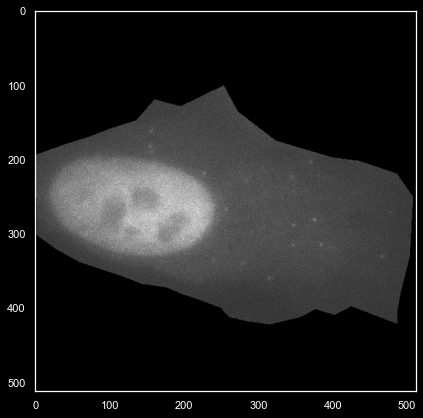

In [75]:
# Create mask from Shapes layer in napari  
width, height = img_croparray.shape[3:5]
polygon=viewer.layers['nucleus'].data[0]
polygon_c = viewer.layers['cell'].data[0]
poly_path=Path(polygon)
poly_path_c = Path(polygon_c)

x, y = np.mgrid[:height, :width]
coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1))) # coors.shape is (4000000,2)

mask = poly_path_c.contains_points(coors)
mask = mask.reshape(height, width)
#mask2 = np.logical_not(mask)

# The masked image should show up as a layer in napari
plt.figure(figsize=(7, 7))
plt.grid(False)
plt.imshow(mask*img_max[0], cmap='gray')

In [487]:
my_channel_axis = np.where(np.array(img_4D.shape) == 3)[0][0]
temp = np.swapaxes(img_4D,0,my_channel_axis)
[(temp[i],) for i in np.arange(len(temp))]


[(13, 512, 512, 65), (13, 512, 512, 65), (13, 512, 512, 65)]

In [478]:
np.array(img_4D.shape)[:,:,:,:,0]

array([ 65,  13, 512, 512,   3])

In [ ]:
np.moveaxis()

In [19]:
from napari.layers import Image, Shapes
from napari.types import LabelsData, ImageData, ShapesData
import napari.types
import trackpy as tp
#viewer.dims.current_step[0] This is how you can access the slider slice in napari

# @magicgui(call_button = 'Load File')
# def open_file(
#     number_of_channels: int,
#     filename = pathlib.Path('/some/path.ext')
# ) -> napari.types.LayerDataTuple:
#     img = imread(filename)
#     my_channel_axis = np.where(np.array(img.shape) == number_of_channels)[0][0]
#     img = np.moveaxis(img_4D,my_channel_axis,0)
#     return [(img[i],{'colormap':'gray','name':'Channel'+str(i)}) for i in np.arange(len(img))]
@magicgui(call_button = 'Make Tracking Channel Layer')
def get_channel(
    image: Image,
    channel_axis: int,
    channel_num: int,
) -> napari.types.LayerDataTuple:
    return (np.expand_dims(np.moveaxis(image.data,channel_axis,0)[channel_num],axis=channel_axis),{'name':image.name+'Ch '+str(channel_num)})

@magicgui(call_button = 'Make Max Projection')
def max_project(
    image1: Image,
    projection_axis: int,
    start_slice: int,
    stop_slice: int,
) -> napari.types.LayerDataTuple:
    return (np.expand_dims(np.max(image1.data, axis=projection_axis),axis=projection_axis),{'name':'Max of '+image1.name})

@magicgui(call_button = 'Detect Spots in Max Projection')
def detect_spots(
    image: Image,
    mask_include: Shapes,
    mask_exclude: Shapes,
    test_frame: int,
    size = 9,
    min_m = 1000,
    detect_spots_in_all_frames = False,
) -> napari.types.LayerDataTuple:
    if detect_spots_in_all_frames:
        f_all = TrackWithMasks(np.squeeze(image.data),size,min_m,mask_include.data[0][:,-2:],mask_exclude.data[0][:,-2:])
        print(f_all)
        print(np.squeeze(image.data).shape)
        data = f_all[['frame','y','x']].values
        layer_name = 'Spots all frames'
    else:
        f = tp.locate(np.squeeze(image.data[test_frame]),diameter=size,minmass=min_m)
        print(f)
        data = f[['y','x']].values
        layer_name = 'Spots frame '+str(test_frame)
    #save_croparray.dir.value = 'test'
    #save_croparray.show()
    return [(data,{'size':size,'edge_color':'yellow','opacity':0.4,'symbol':'ring','name':layer_name}, 'points'),
            (np.max(image,axis=0), {'name': 'Max Projection', 'blending': 'additive'})]

viewer = napari.Viewer()
#viewer = napari.view_image(img_max, name="My Image")
#viewer.window.add_dock_widget(detect_spots)
#viewer.window.add_dock_widget(max_project)
#viewer.window.add_dock_widget(open_file, name='Step 1',area='right')
viewer.window.add_dock_widget(get_channel, name='Get Video',area='right')
dw2 = viewer.window.add_dock_widget(max_project, name='Max Project',area='right')
dw3 = viewer.window.add_dock_widget(detect_spots, name ='Tracking',area='right')
#viewer.window._qt_window.tabifyDockWidget(dw2, dw3)
#viewer.layers.events.changed.connect(detect_spots.reset_choices)

              y           x         mass      size       ecc      signal  \
212  118.064411  436.592287  1073.563564  2.445552  0.352190   57.580221   
286  162.202827  156.099819  2048.273443  1.640244  0.130312  199.231907   
300  170.306046  414.639337  1287.896107  1.867794  0.235668  103.779484   
325  182.588936  154.108454  1937.546702  1.764792  0.110008  189.182506   
354  204.227476  370.326057  2142.109664  1.845708  0.043466  172.407774   
..          ...         ...          ...       ...       ...         ...   
590  332.142479  113.729308  1001.640151  1.959658  0.097292   81.128529   
602  339.813447  278.532717  1806.610195  2.021903  0.137699  112.849514   
638  359.461829  314.212846  2063.629777  1.862212  0.040272  169.025811   
646  361.900127  222.470597  1064.816774  2.174119  0.097319   69.781342   
815  456.260914  180.015476  1019.982840  1.952549  0.214135   86.888964   

     raw_mass        ep  
212   43482.0  0.098301  
286   46620.0  0.077346  
300   441

In [29]:
viewer.layers['Shapes'].data

[]

In [22]:
yo = np.squeeze(viewer.layers['Max of Cell02-1Ch1'].data)
#f = tp.locate(yo[0], diameter=9,minmass=1000)
f_all = TrackWithMasks(yo, 7 ,1000, viewer.layers['Shapes'].data[0][:,-2:], viewer.layers['Shapes [1]'].data[0][:,-2:1])
f

KeyError: "'Max of Cell02-1Ch1' is not in list"

In [8]:
def TrackWithMasks(img_max, particle_diameter ,min_m, mask_include, mask_exclude):
    f = tp.batch(img_max, diameter=particle_diameter,minmass=min_m)
    f_list = []
    for i in np.arange(len(f['frame'].unique())):
        f0 = f[f['frame']==i]
        f1 = f0.copy()

        # If no masks, include everything and exclude nothing
        if mask_include == None:
            mask_include1 = [[0,0],[0,10000000],[10000000,10000000],[10000000,0]]
        if mask_exclude == None:
            mask_exclude1 = [[0,0],[0,-10],[-10,-10]]

        mask_in = Polygon(mask_include1)  # This is a polygon that defines the mask
        mypts = np.transpose([f1.y,f1.x]) # These are the points detected by trackpy, notice the x/y inversion for napari
        f1['Include']=[mask_in.contains(Point(mypts[i])) for i in np.arange(len(mypts))] # Check if pts are on/in polygon mask  

        # # Label points in nucleus if polygon mask exists
        # if polygon != None:
        mask_out = Polygon(mask_exclude1)  # This is a polygon that defines the mask
        f1['Exclude']=[mask_out.contains(Point(mypts[i])) for i in np.arange(len(mypts))] # Check if pts are on/in polygon mask  
        
        f_list.append(f1[(f1['Include']==True) & (f1['Exclude']==False)])
    f_all = pd.concat(f_list)
    return f_all

In [ ]:
(f1['Include']==True)

In [323]:
f

,y,x,mass,size,ecc,signal,raw_mass,ep,In Nucleus
441,162.314288,156.047885,1578.220411,1.529673,0.131884,176.624047,28994.0,0.054826,False
500,182.776411,153.842445,1444.273882,1.508030,0.109588,172.805192,31053.0,0.045938,False
557,204.002477,370.318794,1458.370542,1.573965,0.036774,147.042052,27266.0,0.065455,False
599,218.808402,226.898315,1834.273406,1.413531,0.155329,232.748293,34293.0,0.036601,False
627,231.234459,150.646147,1112.885300,1.781617,0.218430,103.060634,56583.0,0.015261,True
640,233.899015,214.843366,1252.285606,1.671224,0.150588,126.300746,53016.0,0.016831,True
647,236.922367,142.138577,1075.855327,1.560738,0.344726,115.054098,53334.0,0.016678,True
657,238.597428,156.120443,1102.127110,1.630066,0.138614,113.600834,55074.0,0.015888,True
678,247.649565,169.431637,1011.564546,1.472782,0.172812,162.030855,59487.0,0.014183,True
710,260.013026,123.403149,1023.017073,1.600779,0.141732,103.827634,54851.0,0.015985,True


In [313]:
f_all = TrackWithMasks(img_max,7,1000,viewer.layers['Shapes'].data[0][:,1:3],viewer.layers['Shapes'].data[0][:,1:3])
#f_all.to_csv(os.path.join(dir,img_4D_filename[:-4]+'.csv'))

Frame 64: 20 features


In [314]:
f_all

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,Include,Exclude
0,162.314288,156.047885,1578.220411,1.529673,0.131884,176.624047,28994.0,0.054826,0,False,False
1,182.776411,153.842445,1444.273882,1.508030,0.109588,172.805192,31053.0,0.045938,0,False,False
2,204.002477,370.318794,1458.370542,1.573965,0.036774,147.042052,27266.0,0.065455,0,False,False
3,218.808402,226.898315,1834.273406,1.413531,0.155329,232.748293,34293.0,0.036601,0,True,True
4,231.234459,150.646147,1112.885300,1.781617,0.218430,103.060634,56583.0,0.015261,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...
1576,315.323754,277.645780,2523.266035,1.458111,0.138921,307.396064,33674.0,0.037619,64,False,False
1577,343.883454,266.205445,2563.661782,1.506490,0.109865,284.121134,34931.0,0.034808,64,False,False
1578,349.081788,354.329591,1277.320846,1.534719,0.110253,151.863994,28081.0,0.058718,64,False,False
1579,370.930712,257.361687,1187.420138,1.520906,0.088614,146.685533,28488.0,0.056415,64,False,False


Convert f to crop_array format

In [84]:
#only if you didn't track:
spots = f_all.copy() # Nice to copy; seems it can cause to overwrite otherwise
spots['id']=spots.index
spots.rename(columns={'x': 'xc','y': 'yc', 'frame': 'f','signal':'signal_tp'}, 
inplace=True, errors='raise')
spots['fov']=0
spots.rename(columns={'particle':'id'})
spots = spots[['fov','id','f','yc','xc','signal_tp','In Cell','In Nucleus']] # keeping signal out of curiousity... want to compare to disk-donut measurements  
spots.head()

,fov,id,f,yc,xc,signal_tp,In Cell,In Nucleus
0,0,0,0,162.314288,156.047885,176.624047,True,False
1,0,1,0,182.776411,153.842445,172.805192,True,False
2,0,2,0,204.002477,370.318794,147.042052,True,False
3,0,3,0,218.808402,226.898315,232.748293,True,False
4,0,4,0,231.234459,150.646147,103.060634,True,True


## Create Crop Array
____

Create a crop array from 4D movie

In [88]:
my_ca = ca.create_crop_array(img_croparray,spots,xy_pad=particle_diameter//2+1, dxy=130, dz=500, dt=1, units=['nm','min'], name = os.path.join(dir,img_4D_filename))
my_ca

Original video dimensions:  (1, 65, 13, 512, 512, 3)
Padded video dimensions:  (1, 65, 13, 522, 522, 3)
Max # of spots per frame:  37
Shape of numpy array to hold all crop intensity data:  (1, 37, 65, 13, 9, 9, 3)
Shape of xc and yc numpy arrays:  (1, 37, 65, 3)
Shape of extra my_layers numpy array:  (4, 1, 37, 65)


<xarray.Dataset>
Dimensions:     (fov: 1, n: 37, t: 65, z: 13, y: 9, x: 9, ch: 3)
Coordinates:
  * fov         (fov) int32 0
  * n           (n) int16 0 1 2 3 4 5 6 7 8 9 ... 27 28 29 30 31 32 33 34 35 36
  * t           (t) int32 0 1 2 3 4 5 6 7 8 9 ... 55 56 57 58 59 60 61 62 63 64
  * z           (z) int32 0 500 1000 1500 2000 2500 ... 4000 4500 5000 5500 6000
  * y           (y) int32 -4 -3 -2 -1 0 1 2 3 4
  * x           (x) int32 -4 -3 -2 -1 0 1 2 3 4
  * ch          (ch) int32 0 1 2
Data variables:
    int         (fov, n, t, z, y, x, ch) int32 785 652 540 730 689 ... 0 0 0 0 0
    xc          (fov, n, t, ch) int32 161 161 161 161 161 161 ... 0 0 0 0 0 0
    yc          (fov, n, t, ch) int32 167 167 167 174 174 174 ... 0 0 0 0 0 0
    dx          int32 1
    dy          int32 1
    dz          int32 500
    dt          int32 1
    xy_pad      int32 4
    id          (fov, n, t) float64 0.0 30.0 61.0 97.0 134.0 ... 0.0 0.0 0.0 0.0
    signal_tp   (fov, n, t) float64 177.0 125.0 139.0 241.0 ... 0.0 0.0 0.0 0.0
    In Cell     (fov, n, t) float64 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    In Nucleus  (fov, n, t) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    name:     Z:\galindo\1_Imaging_Data\20220210_metabolites\PEP_10mM\Cell02.tif
    date:     video_date

## Save the crop array
____

In [89]:
my_ca.to_netcdf(os.path.join(dir,img_4D_filename[:-4]+'.nc') )

## Quantify signal intensity through time
____

In [90]:
# Measure signals and plot average signal through time, creating 'best_z' layer and 'signal' layer
ca.measure_signal(my_ca, ref_ch=1, disk_r=3, roll_n=3)

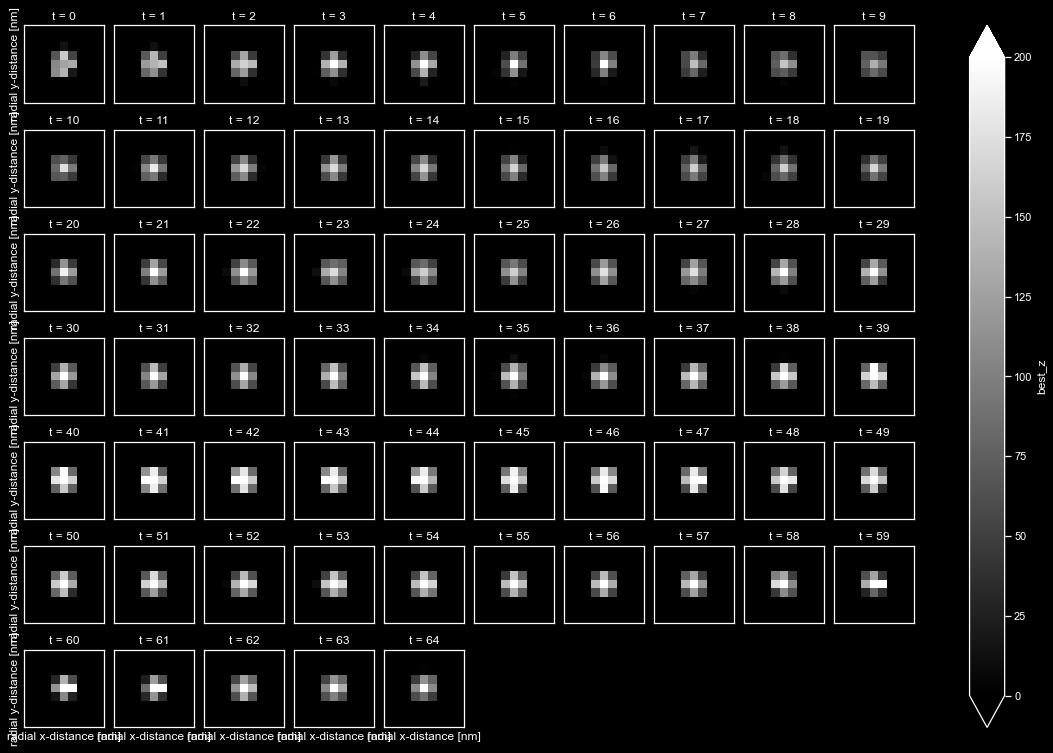

In [91]:
my_ca.best_z.mean('n').sel(fov=0,ch=1).rolling(t=3,min_periods=1).mean().plot.imshow(col='t',col_wrap=10,robust=True,xticks=[],yticks=[],size=1.5,cmap='gray', vmin=0, vmax =200)

Let's compare our disk-donut 'signal' layer (acquired from 3D image) to trackpy's (acquired from max-projection):

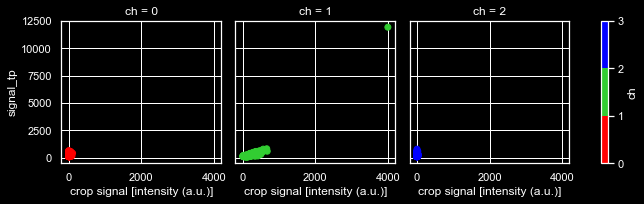

In [93]:
# Let's compare our intensity numbers to those from trackpy:
my_ca.where(my_ca.signal>0).plot.scatter(x='signal',y='signal_tp',col='ch',hue='ch',colors=['red','limegreen','blue'],levels=[0,1,2,3])

Let's look at average signal vs time

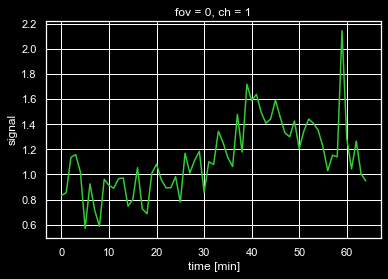

In [94]:
# Let's look at average signal vs time
start_sig = my_ca.signal.mean('n').sel(t=slice(0,4)).mean('t')
end_sig = 0# my_ca.signal.mean('n').sel(t=slice(15,20)).mean('t')
norm_sig = (my_ca.signal.mean('n') - end_sig)/(start_sig - end_sig)
sns.set_palette(['limegreen','limegreen','blue'])
norm_sig.sel(fov=0,ch=1).plot.line(x='t',hue='ch')

Now let's just use trackpy's values:

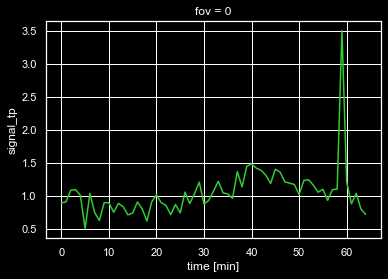

In [95]:
# Let's look at average signal vs time
start_sig = my_ca.signal_tp.mean('n').sel(t=slice(0,4)).mean('t')
end_sig = 0# my_ca.signal_tp.mean('n').sel(t=slice(15,20)).mean('t')
norm_sig = (my_ca.signal_tp.mean('n') - end_sig)/(start_sig - end_sig)
sns.set_palette(['limegreen','limegreen','blue'])
norm_sig.sel(fov=0).plot.line(x='t',hue='ch')

I guess trackpy and the disk donut method do a very good job at getting the intensities of spots. Although note that trackpy got the values from the max-intensity projection. Interesting.

## Visualize crop array montage with Napari
___

Now let's see a montage of the selected spots' best-z planes:

In [96]:
# view the action of montage showing an n x n crop_array through time
viewer = napari.view_image(ca.montage(my_ca.sel(fov=0,ch=0).best_z,row='n',col='t'),contrast_limits=[60,800])

## Optional: Create Track Array
___

In [98]:
f_all

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,In Cell,In Nucleus
0,162.314288,156.047885,1578.220411,1.529673,0.131884,176.624047,28994.0,0.054826,0,True,False
1,182.776411,153.842445,1444.273882,1.508030,0.109588,172.805192,31053.0,0.045938,0,True,False
2,204.002477,370.318794,1458.370542,1.573965,0.036774,147.042052,27266.0,0.065455,0,True,False
3,218.808402,226.898315,1834.273406,1.413531,0.155329,232.748293,34293.0,0.036601,0,True,False
4,231.234459,150.646147,1112.885300,1.781617,0.218430,103.060634,56583.0,0.015261,0,True,True
...,...,...,...,...,...,...,...,...,...,...,...
1576,315.323754,277.645780,2523.266035,1.458111,0.138921,307.396064,33674.0,0.037619,64,True,False
1577,343.883454,266.205445,2563.661782,1.506490,0.109865,284.121134,34931.0,0.034808,64,True,False
1578,349.081788,354.329591,1277.320846,1.534719,0.110253,151.863994,28081.0,0.058718,64,True,False
1579,370.930712,257.361687,1187.420138,1.520906,0.088614,146.685533,28488.0,0.056415,64,True,False


In [99]:
# Note, if you actually wanted to track, you could use the following:
# link tracks
max_distance_movement = 15
track_skip_frames = 3
min_trajectory_length = 10
t = tp.link(f_all, max_distance_movement, memory=track_skip_frames)
t1 = tp.filter_stubs(t, min_trajectory_length)
t1['particle'] = t1['particle']+1 # VERY IMPORTANT NOT TO HAVE TRACK IDs WITH VALUES = 0 WHEN MAKING CROP ARRAYS AS ZERO IS DEFAULT EMPTY VALUE
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique()) 

Frame 64: 20 trajectories present.
Before: 453
After: 30


In [100]:
# only if you tracked:
spots = t1.copy()
spots.rename(columns={'x': 'xc','y': 'yc', 'frame': 'f','signal':'signal_tp','particle':'id'}, 
inplace=True, errors='raise')


spots['fov']=0
spots.rename(columns={'particle':'id'})
spots = spots[['fov','id','f','yc','xc','signal_tp']] # keeping signal out of curiousity... want to compare to disk-donut measurements  
spots.head()

,fov,id,f,yc,xc,signal_tp
frame,,,,,,
0,0,2,0,359.265680,314.304123,141.644791
0,0,13,0,281.979221,213.856341,89.597758
0,0,25,0,247.649565,169.431637,162.030855
0,0,28,0,261.748990,239.128626,110.387506
0,0,29,0,266.199052,202.242530,109.668948


In [101]:
my_ca2 = ca.create_crop_array(img_croparray,spots,xy_pad=particle_diameter//2+1, dxy=130, dz=500, dt=1, units=['nm','min'])

Original video dimensions:  (1, 65, 13, 512, 512, 3)
Padded video dimensions:  (1, 65, 13, 522, 522, 3)
Max # of spots per frame:  13
Shape of numpy array to hold all crop intensity data:  (1, 13, 65, 13, 9, 9, 3)
Shape of xc and yc numpy arrays:  (1, 13, 65, 3)
Shape of extra my_layers numpy array:  (2, 1, 13, 65)


In [102]:
# Measure signals and plot average signal through time, creating 'best_z' layer and 'signal' layer
ca.measure_signal(my_ca2, ref_ch=1, disk_r=3, roll_n=3)

In [103]:
import xarray as xr
import pandas as pd
# Since ids correspond to tracks, we can organize tracks in rows  
my_ids = np.unique(my_ca2.id) # Find all unique ids
my_ids = my_ids[1:] # remove the '0' ID used as filler in Crop Arrays
my_ids
# Get a list of xarrays for each unique id 
my_das = []
for i in np.arange(len(my_ids)):
    temp = my_ca2.groupby('id')[my_ids[i]].reset_index('stacked_fov_n_t').reset_coords('n',drop=True).reset_coords('fov',drop=True).swap_dims({'stacked_fov_n_t':'t'})
    my_das.append(temp)
    del temp
# Concatenate the xarrays together to make a new xarray dataset in a track array format (each track on separate row). Here 'n' is replaced by 'tracks'
my_taz = xr.concat(my_das, dim=pd.Index(my_ids, name='track_id'), fill_value=255) # fill_value=0 so keep int instead of moving to floats with NaNs
my_taz = my_taz.transpose('track_id','fov','n','t','z','y','x','ch', missing_dims='ignore') # reorder for napari
my_taz

<xarray.Dataset>
Dimensions:    (t: 65, z: 13, y: 9, x: 9, ch: 3, track_id: 30)
Coordinates:
  * t          (t) int64 0 1 2 3 4 5 6 7 8 9 ... 55 56 57 58 59 60 61 62 63 64
  * z          (z) int32 0 500 1000 1500 2000 2500 ... 4000 4500 5000 5500 6000
  * y          (y) int32 -4 -3 -2 -1 0 1 2 3 4
  * x          (x) int32 -4 -3 -2 -1 0 1 2 3 4
  * ch         (ch) int64 0 1 2
  * track_id   (track_id) float64 2.0 13.0 25.0 28.0 ... 338.0 353.0 364.0 374.0
Data variables: (12/13)
    int        (track_id, t, z, y, x, ch) int32 686 638 483 690 ... 255 255 255
    xc         (track_id, t, ch) int32 319 319 319 324 324 ... 253 255 255 255
    yc         (track_id, t, ch) int32 364 364 364 374 374 ... 264 255 255 255
    dx         (track_id) int32 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    dy         (track_id) int32 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    dz         (track_id) int32 500 500 500 500 500 500 ... 500 500 500 500 500
    ...         ...
    xy_pad     (track_id) int32 4 4 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 4 4 4 4
    id         (track_id, t) float64 2.0 2.0 2.0 2.0 ... 374.0 374.0 374.0 255.0
    signal_tp  (track_id, t) float64 142.0 235.0 236.0 ... 152.0 89.0 255.0
    zc         (track_id, t) int64 5 6 6 6 6 255 6 6 6 ... 255 4 6 7 5 4 6 5 255
    best_z     (track_id, t, y, x, ch) float64 110.1 -336.7 ... 255.0 255.0
    signal     (track_id, t, ch) float64 -25.06 112.4 -21.34 ... 255.0 255.0
Attributes:
    name:     video_filename
    date:     video_date

In [104]:
# view the action of montage showing an n x n crop_array through time
viewer = napari.view_image(ca.montage(my_taz.sel(ch=1).best_z,row='track_id',col='t'),contrast_limits=[60,800])

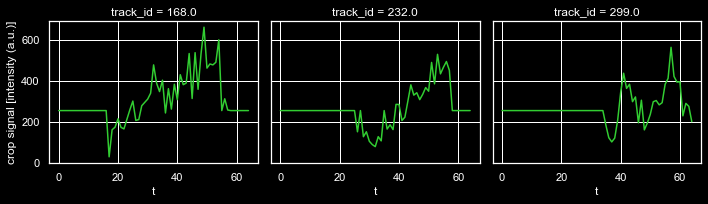

In [105]:
my_taz.isel(track_id=[12,16,20]).sel(ch=1).signal.plot.line(x='t',col='track_id',col_wrap=3)

# Trying to track in x, y, and z:

Measure signals and plot average signal through time, creating 'best_z' layer and 'signal' layer

In [25]:
max_distance_movement = 5
track_skip_frames = 3
my_frame = 15
min_trajectory_length=2
my_list = []
for my_frame in np.arange(len(img_croparray[0,:])): #np.arange(15,16,1):
    f = tp.batch(img_croparray[0,my_frame,:,:,:,1], diameter=7,minmass=1000)
    t1 = tp.link(f, max_distance_movement, memory=track_skip_frames)
    t = tp.filter_stubs(t1, min_trajectory_length)
    sort_t = t.sort_values(['particle']).groupby('particle').aggregate('max').reset_index().rename(columns={'frame':'z'})
    sort_t['t']=my_frame
    my_list.append(sort_t)
my_df = pd.concat(my_list)
my_df.reset_index()

Frame 12: 6 trajectories present.


NameError: name 'pd' is not defined

In [27]:
import pandas as pd
my_df = pd.concat(my_list)
my_df.reset_index()

,index,particle,y,x,mass,size,ecc,signal,raw_mass,ep,z,t
0,0,1,265.126123,179.288674,1628.551584,1.874931,0.456239,223.443949,57427.0,0.018648,7,0
1,1,3,267.046963,205.697036,1414.572406,1.854444,0.323982,172.348805,57278.0,0.020035,11,0
2,2,7,296.339594,146.190013,1404.200152,1.798229,0.419493,162.043243,54490.0,0.016932,6,0
3,3,8,286.356175,214.849965,1466.282876,1.802885,0.275980,148.216038,57679.0,0.020939,8,0
4,4,9,282.030380,129.168233,1497.468179,1.852901,0.297139,196.285890,55725.0,0.021990,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4588,44,110,308.218702,376.070087,4494.276641,1.868788,0.221681,509.585766,35307.0,0.054544,11,64
4589,45,112,374.020162,257.493160,1620.912914,1.624109,0.148189,192.307055,25918.0,0.062328,10,64
4590,46,118,277.154825,202.980465,1130.622733,1.828707,0.432607,172.092273,38823.0,0.028547,11,64
4591,47,122,232.825651,99.334905,1151.751786,1.730539,0.409167,163.599224,36874.0,0.031245,11,64


In [ ]:
my_df['raw_mass'].hist()

In [ ]:
plt.figure(figsize=(20,10))
tp.annotate(my_df[(my_df['t']==28)&(my_df['raw_mass']<40000)], img_4D_max_real[28]);

In [ ]:
np.array([len(t[t['particle']==i].x) for i in np.arange(len(t.particle))])

In [ ]:
f[f['frame']==6]